# Gradient Boosting Machines for Wine Points Predictions

Wine Spectator's 100-Point Scale

95-100 Classic: a great wine.

90-94 Outstanding: a wine of superior character and style.

85-89 Very good: a wine with special qualities.

80-84 Good: a solid, well-made wine.

75-79 Mediocre: a drinkable wine that may have minor flaws.

50-74 Not recommended.

In [ ]:
!pip install xgboost

In [ ]:
!pip install graphviz

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#Load data
wine = pd.read_csv('data/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price"], inplace=True)
wine.reset_index(inplace=True, drop=True)
print(wine.shape)
wine.head()

(137235, 10)


,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
wine["description"][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

In [5]:
print(wine.points.max())
print(wine.points.min())

100
80


min points 80
max points100


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


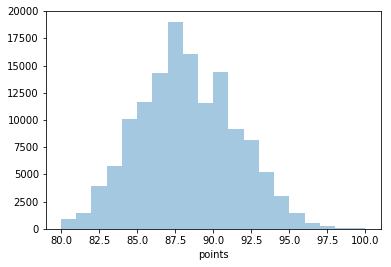

In [6]:
print("min points {}".format(wine.points.min()))
print("max points{}".format(wine.points.max()))

sns.distplot(wine.points, bins=20, kde=False)
plt.show()

# Feature Engineering

In [7]:
def ohe_features(df, feature, occurances):
    '''
    df: pandas data frame with feature to be encoded
    feature: str. feature name
    occurances: number of occurances to threshold feature at
    '''
    vc = df[feature].value_counts()
    keep_values = vc[vc > occurances].index.tolist()
    ohe_feature = pd.get_dummies(df[feature])

    feature_names = ohe_feature.columns
    keep_features = feature_names[feature_names.isin(keep_values)]
    return ohe_feature[keep_features]

def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [8]:
country = pd.get_dummies(wine.country)
collist = country.columns.tolist()
collist = ["country_" + s for s in collist]
country.columns = collist
print ("There are {} country categorical variables".format(country.shape[1]))

designation = ohe_features(wine, "designation", 50)
collist = designation.columns.tolist()
collist = ["designation_" + s for s in collist]
designation.columns = collist
print ("There are {} designation categorical variables".format(designation.shape[1]))

province = ohe_features(wine, "province", 50)
collist = province.columns.tolist()
collist = ["province_" + s for s in collist]
province.columns = collist
print ("There are {} province categorical variables".format(province.shape[1]))

region = ohe_features(wine, "region_1", 50)
collist = region.columns.tolist()
collist = ["region_" + s for s in collist]
region.columns = collist
print ("There are {} region categorical variables".format(region.shape[1]))

variety = ohe_features(wine, "variety", 50)
collist = variety.columns.tolist()
collist = ["variety_" + s for s in collist]
variety.columns = collist
print ("There are {} variety categorical variables".format(variety.shape[1]))

winery = ohe_features(wine, "winery", 50)
collist = winery.columns.tolist()
collist = ["winery_" + s for s in collist]
winery.columns = collist
print ("There are {} winery categorical variables".format(winery.shape[1]))

There are 46 country categorical variables
There are 71 designation categorical variables
There are 113 province categorical variables
There are 308 region categorical variables
There are 133 variety categorical variables
There are 454 winery categorical variables


In [9]:
wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

In [10]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4
0,0.122660,-0.036626,-0.007187,-0.022406,-0.024336
1,0.135296,-0.041505,0.014409,-0.015783,0.004102
2,0.077102,0.046774,-0.015968,-0.007267,0.018448
3,0.147137,-0.096328,0.032715,-0.001577,0.028744
4,0.083745,0.001137,-0.081242,-0.099452,-0.026693


In [11]:
X = pd.concat([country, designation, region, variety, winery, lsa_features, wine["price"]], axis=1)
y = wine["points"]
print (X.shape)
print (y.shape)

(137235, 1018)
(137235,)


# Test Train Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print ("{} training observations".format(X_train.shape[0]))
print ("{} testing observations".format(X_test.shape[0]))

96064 training observations
41171 testing observations


# XGBoost Classification

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [38]:
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

In [39]:
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	test-mae:2.06074	train-mae:2.05771
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	test-mae:1.97453	train-mae:1.96351
[2]	test-mae:1.94195	train-mae:1.92593
[3]	test-mae:1.92774	train-mae:1.91113
[4]	test-mae:1.91011	train-mae:1.89161
[5]	test-mae:1.88505	train-mae:1.86523
[6]	test-mae:1.87471	train-mae:1.85512
[7]	test-mae:1.86947	train-mae:1.84943
[8]	test-mae:1.86603	train-mae:1.84432
[9]	test-mae:1.85193	train-mae:1.82779


In [40]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred["prediction"] = np.round(pred["prediction"],0).astype(int)
pred.sample(5)

,points,prediction
119574,91,88
131562,90,88
128526,89,89
130038,88,88
115681,94,92


In [41]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
mean_ae = np.round(mean_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
print ("Mean Absolute Error: {} points".format(mean_ae))

Mean Absolute Error: 1.84 points


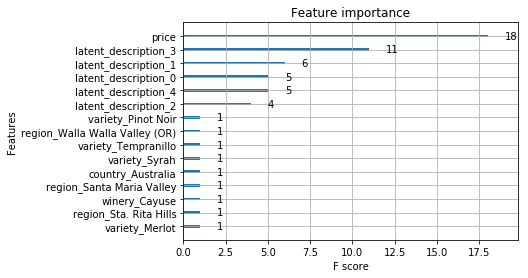

In [42]:
xgb.plot_importance(bst,max_num_features=15)

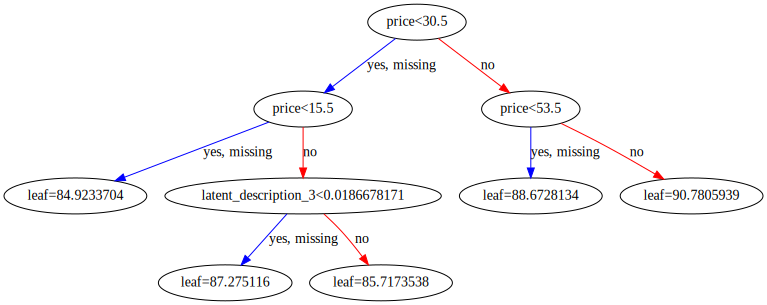

In [43]:
xgb.to_graphviz(bst, num_trees=0)

# DIY Deployment

In [44]:
# I wrote my own predict method 
# Use business logic to filter predictions, not just the models basic predict
# send info in and out as a dictionary/json

In [45]:
def my_own_predict_method(feature_payload):
    
    message_cheap = "Wow, what a steal!"
    message_expensive = "Yikes, that is a spendy wine!"

    #format payload as a dataframe
    x = pd.DataFrame(feature_payload, index=[0])
    #convert it to xgboost data object
    x = xgb.DMatrix(x, label=y_test)

    #predict wine price from xgboost model
    prediction = bst.predict(x, ntree_limit=bst.best_ntree_limit)
    prediction = np.round(prediction,2)[0]
 
    #personalise message 
    if prediction < 50:
        message = message_cheap
    else:
        message = message_expensive
        
    output = {"price": "$"+str(prediction), "message":message}
    
    return output

In [51]:
#get an example payload from the test data
feature_payload = X_test.iloc[5].to_dict()
print(feature_payload)

{'country_Albania': 0.0, 'country_Argentina': 0.0, 'country_Australia': 0.0, 'country_Austria': 0.0, 'country_Bosnia and Herzegovina': 0.0, 'country_Brazil': 0.0, 'country_Bulgaria': 0.0, 'country_Canada': 0.0, 'country_Chile': 0.0, 'country_China': 0.0, 'country_Croatia': 0.0, 'country_Cyprus': 0.0, 'country_Czech Republic': 0.0, 'country_England': 0.0, 'country_France': 0.0, 'country_Georgia': 0.0, 'country_Germany': 0.0, 'country_Greece': 0.0, 'country_Hungary': 0.0, 'country_India': 0.0, 'country_Israel': 0.0, 'country_Italy': 0.0, 'country_Japan': 0.0, 'country_Lebanon': 0.0, 'country_Lithuania': 0.0, 'country_Luxembourg': 0.0, 'country_Macedonia': 0.0, 'country_Mexico': 0.0, 'country_Moldova': 0.0, 'country_Montenegro': 0.0, 'country_Morocco': 0.0, 'country_New Zealand': 0.0, 'country_Portugal': 0.0, 'country_Romania': 0.0, 'country_Serbia': 0.0, 'country_Slovakia': 0.0, 'country_Slovenia': 0.0, 'country_South Africa': 0.0, 'country_South Korea': 0.0, 'country_Spain': 0.0, 'count

In [47]:
non_zero_features = [k for k,v in feature_payload.items() if v > 0]
dict((k, feature_payload[k]) for k in non_zero_features if k in feature_payload)

{'country_US': 1.0,
 'region_Napa Valley': 1.0,
 'variety_Cabernet Sauvignon': 1.0,
 'latent_description_0': 0.08963157398411953,
 'latent_description_3': 0.02880994413163543,
 'latent_description_4': 0.0033397272135805103,
 'price': 20.0}

In [48]:
my_own_predict_method(feature_payload)

ValueError: feature_names mismatch: ['country_Albania', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Bosnia and Herzegovina', 'country_Brazil', 'country_Bulgaria', 'country_Canada', 'country_Chile', 'country_China', 'country_Croatia', 'country_Cyprus', 'country_Czech Republic', 'country_England', 'country_France', 'country_Georgia', 'country_Germany', 'country_Greece', 'country_Hungary', 'country_India', 'country_Israel', 'country_Italy', 'country_Japan', 'country_Lebanon', 'country_Lithuania', 'country_Luxembourg', 'country_Macedonia', 'country_Mexico', 'country_Moldova', 'country_Montenegro', 'country_Morocco', 'country_New Zealand', 'country_Portugal', 'country_Romania', 'country_Serbia', 'country_Slovakia', 'country_Slovenia', 'country_South Africa', 'country_South Korea', 'country_Spain', 'country_Switzerland', 'country_Turkey', 'country_US', 'country_US-France', 'country_Ukraine', 'country_Uruguay', 'designation_Bacigalupi Vineyard', 'designation_Barrel Fermented', 'designation_Barrel Select', 'designation_Bien Nacido Vineyard', 'designation_Blanc de Blancs', 'designation_Blanc de Blancs Brut', 'designation_Broquel', 'designation_Brut', 'designation_Brut Rosé', 'designation_Champoux Vineyard', 'designation_Ciel du Cheval Vineyard', 'designation_Classic', 'designation_Crianza', 'designation_Cuvée Prestige', 'designation_Dry', 'designation_Durell Vineyard', 'designation_Dutton Ranch', 'designation_Estate', 'designation_Estate Bottled', 'designation_Estate Grown', 'designation_Estate Reserve', 'designation_Estate Vineyard', 'designation_Extra Dry', 'designation_Flood Family Vineyards', "designation_Garys' Vineyard", 'designation_Gran Reserva', 'designation_Grand Reserve', 'designation_Kosher', 'designation_La Cruz Vineyard', 'designation_Late Bottled Vintage', 'designation_Late Harvest', 'designation_Limited Edition', 'designation_Limited Release', 'designation_Limited Selection', 'designation_Oak Cask', 'designation_Old Vine', 'designation_Old Vines', 'designation_Premium', 'designation_Prestige', 'designation_Private Reserve', 'designation_Private Selection', "designation_Proprietor's Reserve", 'designation_Red', 'designation_Red Wine', 'designation_Reserva', 'designation_Reserva Especial', 'designation_Reserve', 'designation_Riserva', 'designation_Roble', 'designation_Rosado', "designation_Rosella's Vineyard", 'designation_Rosé', 'designation_Rosé of', 'designation_Réserve', 'designation_Sangiacomo Vineyard', 'designation_Semi-Dry', 'designation_Signature', 'designation_Single Vineyard', 'designation_Sleepy Hollow Vineyard', 'designation_Special Reserve', 'designation_Stagecoach Vineyard', 'designation_Stillwater Creek Vineyard', 'designation_Tinto', 'designation_Tradition', 'designation_Trocken', 'designation_Two Vines', 'designation_Unoaked', 'designation_Vieilles Vignes', 'designation_Vintage', "designation_Vintner's Reserve", 'designation_White', 'region_Adelaide', 'region_Adelaide Hills', 'region_Aglianico del Vulture', 'region_Alexander Valley', 'region_Alicante', 'region_Alsace', 'region_Alto Adige', 'region_Amador County', 'region_Amarone della Valpolicella', 'region_Amarone della Valpolicella Classico', 'region_Anderson Valley', 'region_Anjou', 'region_Applegate Valley', 'region_Argentina', 'region_Arroyo Grande Valley', 'region_Arroyo Seco', 'region_Atlas Peak', 'region_Barbaresco', "region_Barbera d'Alba", "region_Barbera d'Alba Superiore", "region_Barbera d'Asti", "region_Barbera d'Asti Superiore", 'region_Barolo', 'region_Barossa', 'region_Barossa Valley', 'region_Beaujolais', 'region_Beaujolais-Villages', 'region_Beaune', 'region_Bennett Valley', 'region_Bergerac', 'region_Bergerac Sec', 'region_Bierzo', 'region_Blaye Côtes de Bordeaux', 'region_Bolgheri', 'region_Bolgheri Superiore', 'region_Bordeaux', 'region_Bordeaux Blanc', 'region_Bordeaux Rosé', 'region_Bordeaux Supérieur', 'region_Bourgogne', 'region_Brunello di Montalcino', 'region_Cafayate', 'region_Cahors', 'region_Calatayud', 'region_Calaveras County', 'region_Calchaquí Valley', 'region_California', 'region_Calistoga', 'region_Campania', 'region_Campo de Borja', 'region_Cariñena', 'region_Carmel Valley', 'region_Carneros', 'region_Catalunya', 'region_Cava', 'region_Cayuga Lake', 'region_Central Coast', 'region_Chablis', 'region_Chalk Hill', 'region_Chalone', 'region_Chambolle-Musigny', 'region_Champagne', 'region_Chassagne-Montrachet', 'region_Chehalem Mountains', 'region_Chianti', 'region_Chianti Classico', 'region_Chianti Colli Senesi', 'region_Chianti Rufina', 'region_Chinon', 'region_Châteauneuf-du-Pape', 'region_Cienega Valley', 'region_Clare Valley', 'region_Clarendon', 'region_Clarksburg', 'region_Colli Orientali del Friuli', 'region_Colli della Toscana Centrale', 'region_Collio', 'region_Columbia Valley (OR)', 'region_Columbia Valley (WA)', 'region_Conegliano Valdobbiadene Prosecco Superiore', 'region_Contra Costa County', 'region_Coonawarra', 'region_Corbières', 'region_Cornas', 'region_Costières de Nîmes', "region_Coteaux d'Aix-en-Provence", 'region_Coteaux du Languedoc', 'region_Crozes-Hermitage', "region_Crémant d'Alsace", 'region_Crémant de Bourgogne', 'region_Côte Rôtie', 'region_Côtes de Bourg', 'region_Côtes de Gascogne', 'region_Côtes de Provence', 'region_Côtes du Rhône', 'region_Côtes du Rhône Villages', 'region_Delle Venezie', 'region_Diamond Mountain District', "region_Dolcetto d'Alba", 'region_Dry Creek Valley', 'region_Dundee Hills', 'region_Eden Valley', 'region_Edna Valley', 'region_El Dorado', 'region_Eola-Amity Hills', 'region_Etna', 'region_Famatina Valley', 'region_Fiano di Avellino', 'region_Fiddletown', 'region_Finger Lakes', 'region_Franciacorta', 'region_Friuli Grave', 'region_Friuli Isonzo', 'region_Gaillac', 'region_Gevrey-Chambertin', 'region_Gigondas', 'region_Graves', 'region_Greco di Tufo', 'region_Green Valley', 'region_Happy Canyon of Santa Barbara', 'region_Haut-Médoc', 'region_Hermitage', 'region_High Valley', 'region_Horse Heaven Hills', 'region_Howell Mountain', 'region_Hunter Valley', 'region_Irpinia', 'region_Isola dei Nuraghi', 'region_Jerez', 'region_Jumilla', 'region_Knights Valley', 'region_La Mancha', 'region_Lake County', 'region_Langhe', 'region_Langhorne Creek', 'region_Lazio', 'region_Livermore Valley', 'region_Lodi', 'region_Long Island', 'region_Los Carneros', 'region_Lugana', 'region_Luján de Cuyo', 'region_Madiran', 'region_Maipú', 'region_Marche', 'region_Maremma', 'region_Maremma Toscana', 'region_Margaret River', 'region_Margaux', 'region_Marin County', 'region_McLaren Vale', 'region_McMinnville', 'region_Mendocino', 'region_Mendocino County', 'region_Mendocino Ridge', 'region_Mendoza', 'region_Mercurey', 'region_Meursault', 'region_Minervois', "region_Montepulciano d'Abruzzo", 'region_Monterey', 'region_Monterey County', 'region_Monticello', 'region_Montsant', 'region_Morellino di Scansano', "region_Moscato d'Asti", 'region_Mount Veeder', 'region_Mt. Harlan', 'region_Muscadet Sèvre et Maine', 'region_Mâcon-Villages', 'region_Médoc', 'region_Napa', 'region_Napa County', 'region_Napa Valley', 'region_Navarra', 'region_Neuquén', 'region_New Mexico', 'region_New York', 'region_Niagara Peninsula', 'region_North Coast', 'region_North Fork of Long Island', 'region_Nuits-St.-Georges', 'region_Oak Knoll District', 'region_Oakville', 'region_Okanagan Valley', 'region_Oregon', 'region_Paso Robles', 'region_Pauillac', "region_Pays d'Oc", 'region_Penedès', 'region_Pessac-Léognan', 'region_Piedmont', 'region_Pommard', 'region_Pouilly-Fuissé', 'region_Pouilly-Fumé', 'region_Priorat', 'region_Prosecco', 'region_Prosecco Superiore di Cartizze', 'region_Prosecco del Veneto', 'region_Prosecco di Conegliano e Valdobbiadene', 'region_Prosecco di Valdobbiadene', 'region_Puglia', 'region_Puligny-Montrachet', 'region_Rattlesnake Hills', 'region_Red Hills Lake County', 'region_Red Mountain', 'region_Redwood Valley', 'region_Ribbon Ridge', 'region_Ribera del Duero', 'region_Rioja', 'region_Rockpile', 'region_Rogue Valley', 'region_Rosso di Montalcino', 'region_Rosso di Montepulciano', 'region_Rueda', 'region_Russian River Valley', 'region_Rutherford', 'region_Rutherglen', 'region_Rías Baixas', 'region_Río Negro Valley', 'region_Sagrantino di Montefalco', 'region_Saint-Estèphe', 'region_Saint-Joseph', 'region_Saint-Julien', 'region_Saint-Émilion', 'region_Salento', 'region_Salta', 'region_San Benito County', 'region_San Juan', 'region_San Luis Obispo County', 'region_San Rafael', 'region_Sancerre', "region_Sant'Antimo", 'region_Santa Barbara County', 'region_Santa Clara Valley', 'region_Santa Cruz Mountains', 'region_Santa Lucia Highlands', 'region_Santa Maria Valley', 'region_Santa Ynez Valley', 'region_Santenay', 'region_Savigny-lès-Beaune', 'region_Seneca Lake', 'region_Shenandoah Valley (CA)', 'region_Sicilia', 'region_Sierra Foothills', 'region_Snipes Mountain', 'region_Soave', 'region_Soave Classico', 'region_Somontano', 'region_Sonoma Coast', 'region_Sonoma County', 'region_Sonoma Mountain', 'region_Sonoma Valley', 'region_Sonoma-Napa', 'region_South Australia', 'region_South Eastern Australia', 'region_Southern Oregon', 'region_St. Helena', 'region_Sta. Rita Hills', 'region_Stags Leap District', 'region_Taurasi', 'region_Temecula', 'region_Temecula Valley', 'region_Terre Siciliane', 'region_Tierra de Castilla', 'region_Toro', 'region_Toscana', 'region_Trentino', 'region_Trento', 'region_Tupungato', 'region_Uco Valley', 'region_Umbria', 'region_Umpqua Valley', 'region_Utiel-Requena', 'region_Valdeorras', 'region_Valdepeñas', 'region_Valencia', 'region_Valpolicella Classico Superiore', 'region_Valpolicella Classico Superiore Ripasso', 'region_Valpolicella Superiore', 'region_Valpolicella Superiore Ripasso', 'region_Veneto', 'region_Venezia Giulia', 'region_Vermentino di Sardegna', 'region_Vernaccia di San Gimignano', 'region_Victoria', 'region_Vigneti delle Dolomiti', 'region_Vin Mousseux', "region_Vin de Pays d'Oc", 'region_Vin de Pays des Côtes de Gascogne', 'region_Vino Nobile di Montepulciano', 'region_Vino de la Tierra de Castilla', 'region_Vino de la Tierra de Castilla y León', 'region_Virginia', 'region_Volnay', 'region_Vosne-Romanée', 'region_Vouvray', 'region_Wahluke Slope', 'region_Walla Walla Valley (OR)', 'region_Walla Walla Valley (WA)', 'region_Washington', 'region_Western Australia', 'region_Willamette Valley', 'region_Yakima Valley', 'region_Yamhill-Carlton District', 'region_Yarra Valley', 'region_Yorkville Highlands', 'region_Yountville', 'variety_Agiorgitiko', 'variety_Aglianico', 'variety_Albariño', 'variety_Alsace white blend', 'variety_Alvarinho', 'variety_Arinto', 'variety_Arneis', 'variety_Assyrtico', 'variety_Austrian Red Blend', 'variety_Barbera', 'variety_Blaufränkisch', 'variety_Bonarda', 'variety_Bordeaux-style Red Blend', 'variety_Bordeaux-style White Blend', 'variety_Cabernet Blend', 'variety_Cabernet Franc', 'variety_Cabernet Sauvignon', 'variety_Cabernet Sauvignon-Carmenère', 'variety_Cabernet Sauvignon-Malbec', 'variety_Cabernet Sauvignon-Merlot', 'variety_Cabernet Sauvignon-Shiraz', 'variety_Cabernet Sauvignon-Syrah', 'variety_Carignan', 'variety_Carignano', 'variety_Carmenère', 'variety_Champagne Blend', 'variety_Chardonnay', 'variety_Chardonnay-Viognier', 'variety_Chenin Blanc', 'variety_Cortese', 'variety_Corvina, Rondinella, Molinara', 'variety_Dolcetto', 'variety_Falanghina', 'variety_Fiano', 'variety_Friulano', 'variety_Fumé Blanc', 'variety_G-S-M', 'variety_Gamay', 'variety_Garganega', 'variety_Garnacha', 'variety_Gewürztraminer', 'variety_Glera', 'variety_Godello', 'variety_Greco', 'variety_Grenache', 'variety_Grenache Blanc', 'variety_Grenache-Syrah', 'variety_Grillo', 'variety_Grüner Veltliner', 'variety_Lambrusco', 'variety_Malbec', 'variety_Malbec-Cabernet Sauvignon', 'variety_Malbec-Merlot', 'variety_Marsanne', 'variety_Melon', 'variety_Mencía', 'variety_Meritage', 'variety_Merlot', 'variety_Merlot-Cabernet Sauvignon', 'variety_Monastrell', 'variety_Montepulciano', 'variety_Moscato', 'variety_Mourvèdre', 'variety_Muscat', 'variety_Muscat Canelli', 'variety_Nebbiolo', 'variety_Negroamaro', 'variety_Nerello Mascalese', "variety_Nero d'Avola", 'variety_Petit Verdot', 'variety_Petite Sirah', 'variety_Petite Verdot', 'variety_Pinot Bianco', 'variety_Pinot Blanc', 'variety_Pinot Grigio', 'variety_Pinot Gris', 'variety_Pinot Nero', 'variety_Pinot Noir', 'variety_Pinotage', 'variety_Port', 'variety_Portuguese Red', 'variety_Portuguese White', 'variety_Primitivo', 'variety_Prosecco', 'variety_Prugnolo Gentile', 'variety_Red Blend', 'variety_Rhône-style Red Blend', 'variety_Rhône-style White Blend', 'variety_Ribolla Gialla', 'variety_Riesling', 'variety_Rosé', 'variety_Roussanne', 'variety_Sagrantino', 'variety_Sangiovese', 'variety_Sangiovese Grosso', 'variety_Sauvignon', 'variety_Sauvignon Blanc', 'variety_Sauvignon Blanc-Semillon', 'variety_Semillon-Sauvignon Blanc', 'variety_Sherry', 'variety_Shiraz', 'variety_Shiraz-Cabernet Sauvignon', 'variety_Shiraz-Viognier', 'variety_Silvaner', 'variety_Sparkling Blend', 'variety_Spätburgunder', 'variety_St. Laurent', 'variety_Syrah', 'variety_Syrah-Cabernet', 'variety_Sémillon', 'variety_Tannat', 'variety_Tempranillo', 'variety_Tempranillo Blend', 'variety_Tempranillo-Cabernet Sauvignon', 'variety_Tempranillo-Garnacha', 'variety_Tinta de Toro', 'variety_Tinto Fino', 'variety_Tinto del Pais', 'variety_Tokaji', 'variety_Torrontés', 'variety_Touriga Nacional', 'variety_Turbiana', 'variety_Verdejo', 'variety_Verdelho', 'variety_Vermentino', 'variety_Vernaccia', 'variety_Vidal Blanc', 'variety_Viognier', 'variety_Viura', 'variety_White Blend', 'variety_Xinomavro', 'variety_Zinfandel', 'variety_Zweigelt', 'winery_Abacela', 'winery_Abeja', 'winery_Adega Cooperativa de Borba', 'winery_Adelaida', 'winery_Adelsheim', 'winery_Airfield Estates', 'winery_Alexander Valley Vineyards', 'winery_Alexandria Nicole', 'winery_Alta Vista', 'winery_Andeluna', 'winery_Andrew Will', 'winery_Apaltagua', 'winery_Arboleda', 'winery_Arbor Crest', 'winery_Aresti', 'winery_Arista', 'winery_Arrowood', 'winery_Artesa', 'winery_Astoria', 'winery_Babcock', 'winery_Bacalhôa Wines of Portugal', 'winery_Ballentine', 'winery_Balletto', 'winery_Barnard Griffin', 'winery_Barnett', 'winery_Barrister', 'winery_Barton & Guestier', 'winery_Basel Cellars', 'winery_Beaulieu Vineyard', 'winery_Benziger', 'winery_Beringer', 'winery_Bernard Magrez', 'winery_Bernardus', 'winery_Betz Family', 'winery_Bianchi', 'winery_Blackstone', 'winery_Bodega Catena Zapata', 'winery_Bodega Norton', 'winery_Bodegas Navarro López', 'winery_Bodegas Valdemar', 'winery_Bogle', 'winery_Bonterra', 'winery_Borges', 'winery_Bouchard Aîné & Fils', 'winery_Bouchard Père & Fils', 'winery_Boutari', 'winery_Brancott', 'winery_Brander', 'winery_Brian Carter Cellars', 'winery_Bründlmayer', 'winery_Buena Vista', 'winery_Buty', 'winery_Byron', 'winery_CVNE', 'winery_Cadence', 'winery_Calcareous', 'winery_Calera', 'winery_Caliterra', 'winery_Cambria', 'winery_Cameron Hughes', 'winery_Campolargo', 'winery_Cantina Santadi', 'winery_Carlos Basso', 'winery_Carmel', 'winery_Carmen', 'winery_Carpineto', 'winery_Carr', 'winery_Casa Silva', 'winery_Castello Banfi', 'winery_Castle Rock', 'winery_Castoro Cellars', 'winery_Cave B', 'winery_Caves Aliança', 'winery_Cayuse', 'winery_Ceretto', 'winery_Chalk Hill', 'winery_Chandon', 'winery_Chanson Père et Fils', 'winery_Charles Krug', 'winery_Chateau St. Jean', 'winery_Chateau Ste. Michelle', 'winery_Chehalem', 'winery_Chilcas', 'winery_Chimney Rock', 'winery_Cinnabar', 'winery_Clarendon Hills', 'winery_Cline', 'winery_Clos La Chance', 'winery_Clos Pegase', 'winery_Clos du Bois', 'winery_Clos du Val', 'winery_Columbia Crest', 'winery_Columbia Winery', 'winery_Companhia das Quintas', 'winery_Concannon', 'winery_Concha y Toro', 'winery_Cono Sur', 'winery_Covey Run', 'winery_Craggy Range', 'winery_Curtis', 'winery_Cusumano', 'winery_Cuvaison', "winery_D'Arenberg", 'winery_DFJ Vinhos', 'winery_David Hill', 'winery_De Bortoli', 'winery_De Loach', 'winery_De Martino', 'winery_DeLille', 'winery_Del Rio', 'winery_Domaine Faiveley', 'winery_Domaine Jean Bousquet', 'winery_Domaine Serene', 'winery_Domaine Zind-Humbrecht', 'winery_Domaine de la Terre Rouge', 'winery_Domaine des Baumard', 'winery_Domaines Barons de Rothschild (Lafite)', 'winery_Domaines Schlumberger', 'winery_Domdechant Werner', 'winery_Donnafugata', 'winery_Dopff & Irion', 'winery_Doyenne', 'winery_Doña Paula', 'winery_Dr. H. Thanisch (Erben Müller-Burggraef)', 'winery_Dr. Konstantin Frank', 'winery_Dr. Loosen', 'winery_Dr. Pauly Bergweiler', 'winery_Dry Creek Vineyard', 'winery_Duca di Salaparuta', 'winery_Duckhorn', 'winery_Dunham', 'winery_Dusted Valley', 'winery_Dutton Estate', 'winery_Dutton-Goldfield', 'winery_Dão Sul', 'winery_E. Guigal', 'winery_EOS', 'winery_Easton', 'winery_Eberle', 'winery_Echeverria', 'winery_El Coto', 'winery_Emiliana', 'winery_Epiphany', 'winery_Erath', 'winery_Errazuriz', 'winery_Estampa', 'winery_Estancia', 'winery_Etude', 'winery_Failla', 'winery_Familia Schroeder', 'winery_Felton Road', 'winery_Fenestra', 'winery_Ferrari-Carano', 'winery_Fess Parker', 'winery_Fetzer', 'winery_Feudi di San Gregorio', 'winery_Feudo Arancio', 'winery_Fidelitas', 'winery_Finca Sophenia', 'winery_Firestone', 'winery_Flora Springs', 'winery_Fournier Père et Fils', 'winery_Foxen', 'winery_Francis Ford Coppola', 'winery_François Lurton', 'winery_Freemark Abbey', 'winery_Freixenet', 'winery_Fritz', "winery_Frog's Leap", 'winery_Funky Llama', 'winery_Gainey', 'winery_Gamache', 'winery_Gary Farrell', 'winery_Georges Vigouroux', 'winery_Geyser Peak', 'winery_Girard', 'winery_Glenora', 'winery_Gloria Ferrer', 'winery_Golan Heights Winery', 'winery_Goldeneye', 'winery_Gorman', 'winery_Grgich Hills', 'winery_Guenoc', 'winery_Gunter Triebaumer', 'winery_Gérard Bertrand', 'winery_Hahn', 'winery_Handley', 'winery_Hanna', 'winery_Hazlitt 1852 Vineyards', 'winery_Hendry', 'winery_Henri de Villamont', 'winery_Herdade do Esporão', 'winery_Heron Hill', 'winery_Hogue', 'winery_Husch', 'winery_Iron Horse', 'winery_Ironstone', 'winery_J Vineyards & Winery', 'winery_J. & F. Lurton', 'winery_J. Lohr', "winery_Jacob's Creek", 'winery_Jaffurs', 'winery_Januik', 'winery_Joseph Drouhin', 'winery_Joseph Phelps', 'winery_Joseph Swan Vineyards', 'winery_Justin', 'winery_K Vintners', 'winery_Keenan', 'winery_Ken Wright', 'winery_Kendall-Jackson', 'winery_Kenwood', 'winery_Kilikanoon', 'winery_Kim Crawford', 'winery_King Estate', 'winery_Kirkland Signature', 'winery_Kokomo', 'winery_Korbel', 'winery_Kumeu River', 'winery_Kunde', 'winery_Kynsi', "winery_L'Ecole No. 41", 'winery_La Chablisienne', 'winery_La Crema', 'winery_La Fenêtre', 'winery_La Playa', 'winery_La Rochelle', 'winery_Labouré-Roi', 'winery_Laetitia', 'winery_Lagarde', 'winery_Lamoreaux Landing', 'winery_Lapostolle', 'winery_Lava Cap', 'winery_Leeuwin Estate', 'winery_Lemelson', 'winery_Leonetti Cellar', 'winery_Lockwood', 'winery_Longboard', 'winery_Longoria', 'winery_Loring Wine Company', 'winery_Lost Canyon', 'winery_Louis Jadot', 'winery_Louis Latour', 'winery_Louis M. Martini', 'winery_Louis Roederer', 'winery_Lucas & Lewellen', 'winery_Lucien Albrecht', 'winery_Luigi Bosca', 'winery_Luis Felipe Edwards', 'winery_Lungarotti', 'winery_Lynmar', 'winery_M. Chapoutier', 'winery_MacPhail', 'winery_Macari', 'winery_Maddalena', 'winery_Manuel Olivier', 'winery_Marchesi Antinori', 'winery_Marchesi di Barolo', 'winery_Marimar Estate', 'winery_Mark Ryan', 'winery_Marqués de Cáceres', 'winery_Martin & Weyrich', 'winery_Martin Ranch', 'winery_Martin Ray', 'winery_Maryhill', 'winery_Maximin Grünhäuser', 'winery_Mazzei', 'winery_Mazzocco', 'winery_McManis', 'winery_Melrose', 'winery_Melville', 'winery_Merry Edwards', 'winery_Merryvale', 'winery_Michel Torino', 'winery_Midnight', 'winery_Miguel Torres', 'winery_Milbrandt', 'winery_Minassian-Young', 'winery_MontGras', 'winery_Montes', 'winery_Morandé', 'winery_Morgan', 'winery_Mounts', 'winery_Mumm Napa', 'winery_Murphy-Goode', 'winery_Navarro', 'winery_Nefarious Cellars', 'winery_Neil Ellis', 'winery_Nickel & Nickel', 'winery_Niepoort', 'winery_Nieto Senetiner', 'winery_Nittnaus Hans und Christine', 'winery_Novelty Hill', 'winery_Novy', 'winery_O. Fournier', 'winery_Odfjell', 'winery_Ojai', 'winery_Olivier Leflaive', 'winery_Owen Roe', 'winery_Pali', 'winery_Panther Creek', 'winery_Paraiso Vineyards', 'winery_Pascual Toso', 'winery_Patz & Hall', 'winery_Paul Jaboulet Aîné', 'winery_Peachy Canyon', 'winery_Pedroncelli', 'winery_Peirano', 'winery_Peju', 'winery_Penfolds', 'winery_Pessagno', 'winery_Pierre Sparr', 'winery_Pine Ridge', 'winery_Pio Cesare', 'winery_Planeta', 'winery_Ponzi', 'winery_Poças', 'winery_Pratsch', 'winery_Pride Mountain', 'winery_Producteurs Plaimont', 'winery_Quinta de Ventozelo', 'winery_Quinta do Casal Branco', 'winery_Quinta do Portal', 'winery_Quivira', 'winery_Ramos-Pinto', 'winery_Ramón Bilbao', 'winery_Rancho Sisquoc', 'winery_Raymond', 'winery_Recanati', 'winery_Reichsgraf von Kesselstatt', 'winery_Remy-Pannier', 'winery_Renwood', 'winery_Rex Hill', 'winery_Robert Hall', 'winery_Robert Mondavi', 'winery_Rocca delle Macìe', 'winery_Rock Wall', 'winery_Rodney Strong', 'winery_Roessler', 'winery_Rosemount', 'winery_Rosenblum', 'winery_Rusack', 'winery_Rutherford Hill', 'winery_Rutini', 'winery_Saint Clair', 'winery_Salomon-Undhof', 'winery_San Juan Vineyards', 'winery_San Pedro', 'winery_San Simeon', 'winery_Santa Alicia', 'winery_Santa Barbara Winery', 'winery_Santa Carolina', 'winery_Santa Ema', 'winery_Santa Julia', 'winery_Santa Rita', 'winery_Saviah', 'winery_Sbragia', 'winery_Schramsberg', 'winery_Schug', 'winery_Sebastiani', 'winery_Segura Viudas', 'winery_Sequoia Grove', 'winery_Seven Hills', 'winery_Shafer', 'winery_Shannon Ridge', 'winery_Siduri', 'winery_Sierra Cantabria', 'winery_Signorello', 'winery_Simonnet-Febvre', 'winery_Sineann', 'winery_Snoqualmie', 'winery_Sobon Estate', 'winery_Soléna', 'winery_Sparkman', 'winery_Spring Valley Vineyard', 'winery_Spy Valley', 'winery_St. Francis', 'winery_St. Supéry', "winery_Stag's Leap Wine Cellars", 'winery_Standing Stone', 'winery_Steele', 'winery_Stephen Ross', 'winery_Sterling', 'winery_Steven Kent', 'winery_Stevens', 'winery_Summers', 'winery_Sur de los Andes', 'winery_Sylvester', 'winery_Syncline', 'winery_Tablas Creek', 'winery_Talamonti', 'winery_Talbott', 'winery_Talley', 'winery_Tamarack Cellars', 'winery_Tamaya', 'winery_Tandem', 'winery_Tangent', "winery_Tasca d'Almerita", 'winery_Telmo Rodríguez', 'winery_Terlato', 'winery_TerraNoble', 'winery_Terrazas de Los Andes', 'winery_Terre Rouge', 'winery_Tertulia', 'winery_Testarossa', 'winery_Thomas Fogarty', 'winery_Three Rivers', 'winery_Thurston Wolfe', 'winery_Tolosa', 'winery_Tommasi', 'winery_Torii Mor', 'winery_Torres', 'winery_Trapiche', 'winery_Trinchero', 'winery_Trivento', 'winery_Truchard', 'winery_Umani Ronchi', 'winery_Undurraga', 'winery_V. Sattui', 'winery_Valentin Bianchi', "winery_Valle dell'Acate", 'winery_Valley of the Moon', 'winery_Ventisquero', 'winery_Veramonte', 'winery_Villa Maria', 'winery_Vina Robles', 'winery_Vine Cliff', 'winery_Vinum', 'winery_Viu Manent', 'winery_Viña Bisquertt', 'winery_Viña La Rosa', 'winery_Viña Requingua', 'winery_Viña Tabalí', 'winery_Von Strasser', 'winery_Wagner', 'winery_Wakefield Estate', 'winery_Waterbrook', 'winery_Wellington', 'winery_Wente', 'winery_White Oak', 'winery_Willamette Valley Vineyards', 'winery_William Fèvre', 'winery_William Hill Estate', 'winery_Williams Selyem', 'winery_Wilson', 'winery_Wines & Winemakers', 'winery_Winzer Krems', 'winery_Woodward Canyon', 'winery_Wölffer', 'winery_X', 'winery_Yalumba', 'winery_Zaca Mesa', 'winery_Zuccardi', 'winery_Zull', 'latent_description_0', 'latent_description_1', 'latent_description_2', 'latent_description_3', 'latent_description_4', 'price'] ['country_Albania', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Bosnia and Herzegovina', 'country_Brazil', 'country_Bulgaria', 'country_Canada', 'country_Chile', 'country_China', 'country_Croatia', 'country_Cyprus', 'country_Czech Republic', 'country_England', 'country_France', 'country_Georgia', 'country_Germany', 'country_Greece', 'country_Hungary', 'country_India', 'country_Israel', 'country_Italy', 'country_Japan', 'country_Lebanon', 'country_Lithuania', 'country_Luxembourg', 'country_Macedonia', 'country_Mexico', 'country_Moldova', 'country_Montenegro', 'country_Morocco', 'country_New Zealand', 'country_Portugal', 'country_Romania', 'country_Serbia', 'country_Slovakia', 'country_Slovenia', 'country_South Africa', 'country_South Korea', 'country_Spain', 'country_Switzerland', 'country_Turkey', 'country_US', 'country_US-France', 'country_Ukraine', 'country_Uruguay', 'designation_Bacigalupi Vineyard', 'designation_Barrel Fermented', 'designation_Barrel Select', 'designation_Bien Nacido Vineyard', 'designation_Blanc de Blancs', 'designation_Blanc de Blancs Brut', 'designation_Broquel', 'designation_Brut', 'designation_Brut Rosé', 'designation_Champoux Vineyard', 'designation_Ciel du Cheval Vineyard', 'designation_Classic', 'designation_Crianza', 'designation_Cuvée Prestige', 'designation_Dry', 'designation_Durell Vineyard', 'designation_Dutton Ranch', 'designation_Estate', 'designation_Estate Bottled', 'designation_Estate Grown', 'designation_Estate Reserve', 'designation_Estate Vineyard', 'designation_Extra Dry', 'designation_Flood Family Vineyards', "designation_Garys' Vineyard", 'designation_Gran Reserva', 'designation_Grand Reserve', 'designation_Kosher', 'designation_La Cruz Vineyard', 'designation_Late Bottled Vintage', 'designation_Late Harvest', 'designation_Limited Edition', 'designation_Limited Release', 'designation_Limited Selection', 'designation_Oak Cask', 'designation_Old Vine', 'designation_Old Vines', 'designation_Premium', 'designation_Prestige', 'designation_Private Reserve', 'designation_Private Selection', "designation_Proprietor's Reserve", 'designation_Red', 'designation_Red Wine', 'designation_Reserva', 'designation_Reserva Especial', 'designation_Reserve', 'designation_Riserva', 'designation_Roble', 'designation_Rosado', "designation_Rosella's Vineyard", 'designation_Rosé', 'designation_Rosé of', 'designation_Réserve', 'designation_Sangiacomo Vineyard', 'designation_Semi-Dry', 'designation_Signature', 'designation_Single Vineyard', 'designation_Sleepy Hollow Vineyard', 'designation_Special Reserve', 'designation_Stagecoach Vineyard', 'designation_Stillwater Creek Vineyard', 'designation_Tinto', 'designation_Tradition', 'designation_Trocken', 'designation_Two Vines', 'designation_Unoaked', 'designation_Vieilles Vignes', 'designation_Vintage', "designation_Vintner's Reserve", 'designation_White', 'latent_description_0', 'latent_description_1', 'latent_description_2', 'latent_description_3', 'latent_description_4', 'price', 'region_Adelaide', 'region_Adelaide Hills', 'region_Aglianico del Vulture', 'region_Alexander Valley', 'region_Alicante', 'region_Alsace', 'region_Alto Adige', 'region_Amador County', 'region_Amarone della Valpolicella', 'region_Amarone della Valpolicella Classico', 'region_Anderson Valley', 'region_Anjou', 'region_Applegate Valley', 'region_Argentina', 'region_Arroyo Grande Valley', 'region_Arroyo Seco', 'region_Atlas Peak', 'region_Barbaresco', "region_Barbera d'Alba", "region_Barbera d'Alba Superiore", "region_Barbera d'Asti", "region_Barbera d'Asti Superiore", 'region_Barolo', 'region_Barossa', 'region_Barossa Valley', 'region_Beaujolais', 'region_Beaujolais-Villages', 'region_Beaune', 'region_Bennett Valley', 'region_Bergerac', 'region_Bergerac Sec', 'region_Bierzo', 'region_Blaye Côtes de Bordeaux', 'region_Bolgheri', 'region_Bolgheri Superiore', 'region_Bordeaux', 'region_Bordeaux Blanc', 'region_Bordeaux Rosé', 'region_Bordeaux Supérieur', 'region_Bourgogne', 'region_Brunello di Montalcino', 'region_Cafayate', 'region_Cahors', 'region_Calatayud', 'region_Calaveras County', 'region_Calchaquí Valley', 'region_California', 'region_Calistoga', 'region_Campania', 'region_Campo de Borja', 'region_Cariñena', 'region_Carmel Valley', 'region_Carneros', 'region_Catalunya', 'region_Cava', 'region_Cayuga Lake', 'region_Central Coast', 'region_Chablis', 'region_Chalk Hill', 'region_Chalone', 'region_Chambolle-Musigny', 'region_Champagne', 'region_Chassagne-Montrachet', 'region_Chehalem Mountains', 'region_Chianti', 'region_Chianti Classico', 'region_Chianti Colli Senesi', 'region_Chianti Rufina', 'region_Chinon', 'region_Châteauneuf-du-Pape', 'region_Cienega Valley', 'region_Clare Valley', 'region_Clarendon', 'region_Clarksburg', 'region_Colli Orientali del Friuli', 'region_Colli della Toscana Centrale', 'region_Collio', 'region_Columbia Valley (OR)', 'region_Columbia Valley (WA)', 'region_Conegliano Valdobbiadene Prosecco Superiore', 'region_Contra Costa County', 'region_Coonawarra', 'region_Corbières', 'region_Cornas', 'region_Costières de Nîmes', "region_Coteaux d'Aix-en-Provence", 'region_Coteaux du Languedoc', 'region_Crozes-Hermitage', "region_Crémant d'Alsace", 'region_Crémant de Bourgogne', 'region_Côte Rôtie', 'region_Côtes de Bourg', 'region_Côtes de Gascogne', 'region_Côtes de Provence', 'region_Côtes du Rhône', 'region_Côtes du Rhône Villages', 'region_Delle Venezie', 'region_Diamond Mountain District', "region_Dolcetto d'Alba", 'region_Dry Creek Valley', 'region_Dundee Hills', 'region_Eden Valley', 'region_Edna Valley', 'region_El Dorado', 'region_Eola-Amity Hills', 'region_Etna', 'region_Famatina Valley', 'region_Fiano di Avellino', 'region_Fiddletown', 'region_Finger Lakes', 'region_Franciacorta', 'region_Friuli Grave', 'region_Friuli Isonzo', 'region_Gaillac', 'region_Gevrey-Chambertin', 'region_Gigondas', 'region_Graves', 'region_Greco di Tufo', 'region_Green Valley', 'region_Happy Canyon of Santa Barbara', 'region_Haut-Médoc', 'region_Hermitage', 'region_High Valley', 'region_Horse Heaven Hills', 'region_Howell Mountain', 'region_Hunter Valley', 'region_Irpinia', 'region_Isola dei Nuraghi', 'region_Jerez', 'region_Jumilla', 'region_Knights Valley', 'region_La Mancha', 'region_Lake County', 'region_Langhe', 'region_Langhorne Creek', 'region_Lazio', 'region_Livermore Valley', 'region_Lodi', 'region_Long Island', 'region_Los Carneros', 'region_Lugana', 'region_Luján de Cuyo', 'region_Madiran', 'region_Maipú', 'region_Marche', 'region_Maremma', 'region_Maremma Toscana', 'region_Margaret River', 'region_Margaux', 'region_Marin County', 'region_McLaren Vale', 'region_McMinnville', 'region_Mendocino', 'region_Mendocino County', 'region_Mendocino Ridge', 'region_Mendoza', 'region_Mercurey', 'region_Meursault', 'region_Minervois', "region_Montepulciano d'Abruzzo", 'region_Monterey', 'region_Monterey County', 'region_Monticello', 'region_Montsant', 'region_Morellino di Scansano', "region_Moscato d'Asti", 'region_Mount Veeder', 'region_Mt. Harlan', 'region_Muscadet Sèvre et Maine', 'region_Mâcon-Villages', 'region_Médoc', 'region_Napa', 'region_Napa County', 'region_Napa Valley', 'region_Navarra', 'region_Neuquén', 'region_New Mexico', 'region_New York', 'region_Niagara Peninsula', 'region_North Coast', 'region_North Fork of Long Island', 'region_Nuits-St.-Georges', 'region_Oak Knoll District', 'region_Oakville', 'region_Okanagan Valley', 'region_Oregon', 'region_Paso Robles', 'region_Pauillac', "region_Pays d'Oc", 'region_Penedès', 'region_Pessac-Léognan', 'region_Piedmont', 'region_Pommard', 'region_Pouilly-Fuissé', 'region_Pouilly-Fumé', 'region_Priorat', 'region_Prosecco', 'region_Prosecco Superiore di Cartizze', 'region_Prosecco del Veneto', 'region_Prosecco di Conegliano e Valdobbiadene', 'region_Prosecco di Valdobbiadene', 'region_Puglia', 'region_Puligny-Montrachet', 'region_Rattlesnake Hills', 'region_Red Hills Lake County', 'region_Red Mountain', 'region_Redwood Valley', 'region_Ribbon Ridge', 'region_Ribera del Duero', 'region_Rioja', 'region_Rockpile', 'region_Rogue Valley', 'region_Rosso di Montalcino', 'region_Rosso di Montepulciano', 'region_Rueda', 'region_Russian River Valley', 'region_Rutherford', 'region_Rutherglen', 'region_Rías Baixas', 'region_Río Negro Valley', 'region_Sagrantino di Montefalco', 'region_Saint-Estèphe', 'region_Saint-Joseph', 'region_Saint-Julien', 'region_Saint-Émilion', 'region_Salento', 'region_Salta', 'region_San Benito County', 'region_San Juan', 'region_San Luis Obispo County', 'region_San Rafael', 'region_Sancerre', "region_Sant'Antimo", 'region_Santa Barbara County', 'region_Santa Clara Valley', 'region_Santa Cruz Mountains', 'region_Santa Lucia Highlands', 'region_Santa Maria Valley', 'region_Santa Ynez Valley', 'region_Santenay', 'region_Savigny-lès-Beaune', 'region_Seneca Lake', 'region_Shenandoah Valley (CA)', 'region_Sicilia', 'region_Sierra Foothills', 'region_Snipes Mountain', 'region_Soave', 'region_Soave Classico', 'region_Somontano', 'region_Sonoma Coast', 'region_Sonoma County', 'region_Sonoma Mountain', 'region_Sonoma Valley', 'region_Sonoma-Napa', 'region_South Australia', 'region_South Eastern Australia', 'region_Southern Oregon', 'region_St. Helena', 'region_Sta. Rita Hills', 'region_Stags Leap District', 'region_Taurasi', 'region_Temecula', 'region_Temecula Valley', 'region_Terre Siciliane', 'region_Tierra de Castilla', 'region_Toro', 'region_Toscana', 'region_Trentino', 'region_Trento', 'region_Tupungato', 'region_Uco Valley', 'region_Umbria', 'region_Umpqua Valley', 'region_Utiel-Requena', 'region_Valdeorras', 'region_Valdepeñas', 'region_Valencia', 'region_Valpolicella Classico Superiore', 'region_Valpolicella Classico Superiore Ripasso', 'region_Valpolicella Superiore', 'region_Valpolicella Superiore Ripasso', 'region_Veneto', 'region_Venezia Giulia', 'region_Vermentino di Sardegna', 'region_Vernaccia di San Gimignano', 'region_Victoria', 'region_Vigneti delle Dolomiti', 'region_Vin Mousseux', "region_Vin de Pays d'Oc", 'region_Vin de Pays des Côtes de Gascogne', 'region_Vino Nobile di Montepulciano', 'region_Vino de la Tierra de Castilla', 'region_Vino de la Tierra de Castilla y León', 'region_Virginia', 'region_Volnay', 'region_Vosne-Romanée', 'region_Vouvray', 'region_Wahluke Slope', 'region_Walla Walla Valley (OR)', 'region_Walla Walla Valley (WA)', 'region_Washington', 'region_Western Australia', 'region_Willamette Valley', 'region_Yakima Valley', 'region_Yamhill-Carlton District', 'region_Yarra Valley', 'region_Yorkville Highlands', 'region_Yountville', 'variety_Agiorgitiko', 'variety_Aglianico', 'variety_Albariño', 'variety_Alsace white blend', 'variety_Alvarinho', 'variety_Arinto', 'variety_Arneis', 'variety_Assyrtico', 'variety_Austrian Red Blend', 'variety_Barbera', 'variety_Blaufränkisch', 'variety_Bonarda', 'variety_Bordeaux-style Red Blend', 'variety_Bordeaux-style White Blend', 'variety_Cabernet Blend', 'variety_Cabernet Franc', 'variety_Cabernet Sauvignon', 'variety_Cabernet Sauvignon-Carmenère', 'variety_Cabernet Sauvignon-Malbec', 'variety_Cabernet Sauvignon-Merlot', 'variety_Cabernet Sauvignon-Shiraz', 'variety_Cabernet Sauvignon-Syrah', 'variety_Carignan', 'variety_Carignano', 'variety_Carmenère', 'variety_Champagne Blend', 'variety_Chardonnay', 'variety_Chardonnay-Viognier', 'variety_Chenin Blanc', 'variety_Cortese', 'variety_Corvina, Rondinella, Molinara', 'variety_Dolcetto', 'variety_Falanghina', 'variety_Fiano', 'variety_Friulano', 'variety_Fumé Blanc', 'variety_G-S-M', 'variety_Gamay', 'variety_Garganega', 'variety_Garnacha', 'variety_Gewürztraminer', 'variety_Glera', 'variety_Godello', 'variety_Greco', 'variety_Grenache', 'variety_Grenache Blanc', 'variety_Grenache-Syrah', 'variety_Grillo', 'variety_Grüner Veltliner', 'variety_Lambrusco', 'variety_Malbec', 'variety_Malbec-Cabernet Sauvignon', 'variety_Malbec-Merlot', 'variety_Marsanne', 'variety_Melon', 'variety_Mencía', 'variety_Meritage', 'variety_Merlot', 'variety_Merlot-Cabernet Sauvignon', 'variety_Monastrell', 'variety_Montepulciano', 'variety_Moscato', 'variety_Mourvèdre', 'variety_Muscat', 'variety_Muscat Canelli', 'variety_Nebbiolo', 'variety_Negroamaro', 'variety_Nerello Mascalese', "variety_Nero d'Avola", 'variety_Petit Verdot', 'variety_Petite Sirah', 'variety_Petite Verdot', 'variety_Pinot Bianco', 'variety_Pinot Blanc', 'variety_Pinot Grigio', 'variety_Pinot Gris', 'variety_Pinot Nero', 'variety_Pinot Noir', 'variety_Pinotage', 'variety_Port', 'variety_Portuguese Red', 'variety_Portuguese White', 'variety_Primitivo', 'variety_Prosecco', 'variety_Prugnolo Gentile', 'variety_Red Blend', 'variety_Rhône-style Red Blend', 'variety_Rhône-style White Blend', 'variety_Ribolla Gialla', 'variety_Riesling', 'variety_Rosé', 'variety_Roussanne', 'variety_Sagrantino', 'variety_Sangiovese', 'variety_Sangiovese Grosso', 'variety_Sauvignon', 'variety_Sauvignon Blanc', 'variety_Sauvignon Blanc-Semillon', 'variety_Semillon-Sauvignon Blanc', 'variety_Sherry', 'variety_Shiraz', 'variety_Shiraz-Cabernet Sauvignon', 'variety_Shiraz-Viognier', 'variety_Silvaner', 'variety_Sparkling Blend', 'variety_Spätburgunder', 'variety_St. Laurent', 'variety_Syrah', 'variety_Syrah-Cabernet', 'variety_Sémillon', 'variety_Tannat', 'variety_Tempranillo', 'variety_Tempranillo Blend', 'variety_Tempranillo-Cabernet Sauvignon', 'variety_Tempranillo-Garnacha', 'variety_Tinta de Toro', 'variety_Tinto Fino', 'variety_Tinto del Pais', 'variety_Tokaji', 'variety_Torrontés', 'variety_Touriga Nacional', 'variety_Turbiana', 'variety_Verdejo', 'variety_Verdelho', 'variety_Vermentino', 'variety_Vernaccia', 'variety_Vidal Blanc', 'variety_Viognier', 'variety_Viura', 'variety_White Blend', 'variety_Xinomavro', 'variety_Zinfandel', 'variety_Zweigelt', 'winery_Abacela', 'winery_Abeja', 'winery_Adega Cooperativa de Borba', 'winery_Adelaida', 'winery_Adelsheim', 'winery_Airfield Estates', 'winery_Alexander Valley Vineyards', 'winery_Alexandria Nicole', 'winery_Alta Vista', 'winery_Andeluna', 'winery_Andrew Will', 'winery_Apaltagua', 'winery_Arboleda', 'winery_Arbor Crest', 'winery_Aresti', 'winery_Arista', 'winery_Arrowood', 'winery_Artesa', 'winery_Astoria', 'winery_Babcock', 'winery_Bacalhôa Wines of Portugal', 'winery_Ballentine', 'winery_Balletto', 'winery_Barnard Griffin', 'winery_Barnett', 'winery_Barrister', 'winery_Barton & Guestier', 'winery_Basel Cellars', 'winery_Beaulieu Vineyard', 'winery_Benziger', 'winery_Beringer', 'winery_Bernard Magrez', 'winery_Bernardus', 'winery_Betz Family', 'winery_Bianchi', 'winery_Blackstone', 'winery_Bodega Catena Zapata', 'winery_Bodega Norton', 'winery_Bodegas Navarro López', 'winery_Bodegas Valdemar', 'winery_Bogle', 'winery_Bonterra', 'winery_Borges', 'winery_Bouchard Aîné & Fils', 'winery_Bouchard Père & Fils', 'winery_Boutari', 'winery_Brancott', 'winery_Brander', 'winery_Brian Carter Cellars', 'winery_Bründlmayer', 'winery_Buena Vista', 'winery_Buty', 'winery_Byron', 'winery_CVNE', 'winery_Cadence', 'winery_Calcareous', 'winery_Calera', 'winery_Caliterra', 'winery_Cambria', 'winery_Cameron Hughes', 'winery_Campolargo', 'winery_Cantina Santadi', 'winery_Carlos Basso', 'winery_Carmel', 'winery_Carmen', 'winery_Carpineto', 'winery_Carr', 'winery_Casa Silva', 'winery_Castello Banfi', 'winery_Castle Rock', 'winery_Castoro Cellars', 'winery_Cave B', 'winery_Caves Aliança', 'winery_Cayuse', 'winery_Ceretto', 'winery_Chalk Hill', 'winery_Chandon', 'winery_Chanson Père et Fils', 'winery_Charles Krug', 'winery_Chateau St. Jean', 'winery_Chateau Ste. Michelle', 'winery_Chehalem', 'winery_Chilcas', 'winery_Chimney Rock', 'winery_Cinnabar', 'winery_Clarendon Hills', 'winery_Cline', 'winery_Clos La Chance', 'winery_Clos Pegase', 'winery_Clos du Bois', 'winery_Clos du Val', 'winery_Columbia Crest', 'winery_Columbia Winery', 'winery_Companhia das Quintas', 'winery_Concannon', 'winery_Concha y Toro', 'winery_Cono Sur', 'winery_Covey Run', 'winery_Craggy Range', 'winery_Curtis', 'winery_Cusumano', 'winery_Cuvaison', "winery_D'Arenberg", 'winery_DFJ Vinhos', 'winery_David Hill', 'winery_De Bortoli', 'winery_De Loach', 'winery_De Martino', 'winery_DeLille', 'winery_Del Rio', 'winery_Domaine Faiveley', 'winery_Domaine Jean Bousquet', 'winery_Domaine Serene', 'winery_Domaine Zind-Humbrecht', 'winery_Domaine de la Terre Rouge', 'winery_Domaine des Baumard', 'winery_Domaines Barons de Rothschild (Lafite)', 'winery_Domaines Schlumberger', 'winery_Domdechant Werner', 'winery_Donnafugata', 'winery_Dopff & Irion', 'winery_Doyenne', 'winery_Doña Paula', 'winery_Dr. H. Thanisch (Erben Müller-Burggraef)', 'winery_Dr. Konstantin Frank', 'winery_Dr. Loosen', 'winery_Dr. Pauly Bergweiler', 'winery_Dry Creek Vineyard', 'winery_Duca di Salaparuta', 'winery_Duckhorn', 'winery_Dunham', 'winery_Dusted Valley', 'winery_Dutton Estate', 'winery_Dutton-Goldfield', 'winery_Dão Sul', 'winery_E. Guigal', 'winery_EOS', 'winery_Easton', 'winery_Eberle', 'winery_Echeverria', 'winery_El Coto', 'winery_Emiliana', 'winery_Epiphany', 'winery_Erath', 'winery_Errazuriz', 'winery_Estampa', 'winery_Estancia', 'winery_Etude', 'winery_Failla', 'winery_Familia Schroeder', 'winery_Felton Road', 'winery_Fenestra', 'winery_Ferrari-Carano', 'winery_Fess Parker', 'winery_Fetzer', 'winery_Feudi di San Gregorio', 'winery_Feudo Arancio', 'winery_Fidelitas', 'winery_Finca Sophenia', 'winery_Firestone', 'winery_Flora Springs', 'winery_Fournier Père et Fils', 'winery_Foxen', 'winery_Francis Ford Coppola', 'winery_François Lurton', 'winery_Freemark Abbey', 'winery_Freixenet', 'winery_Fritz', "winery_Frog's Leap", 'winery_Funky Llama', 'winery_Gainey', 'winery_Gamache', 'winery_Gary Farrell', 'winery_Georges Vigouroux', 'winery_Geyser Peak', 'winery_Girard', 'winery_Glenora', 'winery_Gloria Ferrer', 'winery_Golan Heights Winery', 'winery_Goldeneye', 'winery_Gorman', 'winery_Grgich Hills', 'winery_Guenoc', 'winery_Gunter Triebaumer', 'winery_Gérard Bertrand', 'winery_Hahn', 'winery_Handley', 'winery_Hanna', 'winery_Hazlitt 1852 Vineyards', 'winery_Hendry', 'winery_Henri de Villamont', 'winery_Herdade do Esporão', 'winery_Heron Hill', 'winery_Hogue', 'winery_Husch', 'winery_Iron Horse', 'winery_Ironstone', 'winery_J Vineyards & Winery', 'winery_J. & F. Lurton', 'winery_J. Lohr', "winery_Jacob's Creek", 'winery_Jaffurs', 'winery_Januik', 'winery_Joseph Drouhin', 'winery_Joseph Phelps', 'winery_Joseph Swan Vineyards', 'winery_Justin', 'winery_K Vintners', 'winery_Keenan', 'winery_Ken Wright', 'winery_Kendall-Jackson', 'winery_Kenwood', 'winery_Kilikanoon', 'winery_Kim Crawford', 'winery_King Estate', 'winery_Kirkland Signature', 'winery_Kokomo', 'winery_Korbel', 'winery_Kumeu River', 'winery_Kunde', 'winery_Kynsi', "winery_L'Ecole No. 41", 'winery_La Chablisienne', 'winery_La Crema', 'winery_La Fenêtre', 'winery_La Playa', 'winery_La Rochelle', 'winery_Labouré-Roi', 'winery_Laetitia', 'winery_Lagarde', 'winery_Lamoreaux Landing', 'winery_Lapostolle', 'winery_Lava Cap', 'winery_Leeuwin Estate', 'winery_Lemelson', 'winery_Leonetti Cellar', 'winery_Lockwood', 'winery_Longboard', 'winery_Longoria', 'winery_Loring Wine Company', 'winery_Lost Canyon', 'winery_Louis Jadot', 'winery_Louis Latour', 'winery_Louis M. Martini', 'winery_Louis Roederer', 'winery_Lucas & Lewellen', 'winery_Lucien Albrecht', 'winery_Luigi Bosca', 'winery_Luis Felipe Edwards', 'winery_Lungarotti', 'winery_Lynmar', 'winery_M. Chapoutier', 'winery_MacPhail', 'winery_Macari', 'winery_Maddalena', 'winery_Manuel Olivier', 'winery_Marchesi Antinori', 'winery_Marchesi di Barolo', 'winery_Marimar Estate', 'winery_Mark Ryan', 'winery_Marqués de Cáceres', 'winery_Martin & Weyrich', 'winery_Martin Ranch', 'winery_Martin Ray', 'winery_Maryhill', 'winery_Maximin Grünhäuser', 'winery_Mazzei', 'winery_Mazzocco', 'winery_McManis', 'winery_Melrose', 'winery_Melville', 'winery_Merry Edwards', 'winery_Merryvale', 'winery_Michel Torino', 'winery_Midnight', 'winery_Miguel Torres', 'winery_Milbrandt', 'winery_Minassian-Young', 'winery_MontGras', 'winery_Montes', 'winery_Morandé', 'winery_Morgan', 'winery_Mounts', 'winery_Mumm Napa', 'winery_Murphy-Goode', 'winery_Navarro', 'winery_Nefarious Cellars', 'winery_Neil Ellis', 'winery_Nickel & Nickel', 'winery_Niepoort', 'winery_Nieto Senetiner', 'winery_Nittnaus Hans und Christine', 'winery_Novelty Hill', 'winery_Novy', 'winery_O. Fournier', 'winery_Odfjell', 'winery_Ojai', 'winery_Olivier Leflaive', 'winery_Owen Roe', 'winery_Pali', 'winery_Panther Creek', 'winery_Paraiso Vineyards', 'winery_Pascual Toso', 'winery_Patz & Hall', 'winery_Paul Jaboulet Aîné', 'winery_Peachy Canyon', 'winery_Pedroncelli', 'winery_Peirano', 'winery_Peju', 'winery_Penfolds', 'winery_Pessagno', 'winery_Pierre Sparr', 'winery_Pine Ridge', 'winery_Pio Cesare', 'winery_Planeta', 'winery_Ponzi', 'winery_Poças', 'winery_Pratsch', 'winery_Pride Mountain', 'winery_Producteurs Plaimont', 'winery_Quinta de Ventozelo', 'winery_Quinta do Casal Branco', 'winery_Quinta do Portal', 'winery_Quivira', 'winery_Ramos-Pinto', 'winery_Ramón Bilbao', 'winery_Rancho Sisquoc', 'winery_Raymond', 'winery_Recanati', 'winery_Reichsgraf von Kesselstatt', 'winery_Remy-Pannier', 'winery_Renwood', 'winery_Rex Hill', 'winery_Robert Hall', 'winery_Robert Mondavi', 'winery_Rocca delle Macìe', 'winery_Rock Wall', 'winery_Rodney Strong', 'winery_Roessler', 'winery_Rosemount', 'winery_Rosenblum', 'winery_Rusack', 'winery_Rutherford Hill', 'winery_Rutini', 'winery_Saint Clair', 'winery_Salomon-Undhof', 'winery_San Juan Vineyards', 'winery_San Pedro', 'winery_San Simeon', 'winery_Santa Alicia', 'winery_Santa Barbara Winery', 'winery_Santa Carolina', 'winery_Santa Ema', 'winery_Santa Julia', 'winery_Santa Rita', 'winery_Saviah', 'winery_Sbragia', 'winery_Schramsberg', 'winery_Schug', 'winery_Sebastiani', 'winery_Segura Viudas', 'winery_Sequoia Grove', 'winery_Seven Hills', 'winery_Shafer', 'winery_Shannon Ridge', 'winery_Siduri', 'winery_Sierra Cantabria', 'winery_Signorello', 'winery_Simonnet-Febvre', 'winery_Sineann', 'winery_Snoqualmie', 'winery_Sobon Estate', 'winery_Soléna', 'winery_Sparkman', 'winery_Spring Valley Vineyard', 'winery_Spy Valley', 'winery_St. Francis', 'winery_St. Supéry', "winery_Stag's Leap Wine Cellars", 'winery_Standing Stone', 'winery_Steele', 'winery_Stephen Ross', 'winery_Sterling', 'winery_Steven Kent', 'winery_Stevens', 'winery_Summers', 'winery_Sur de los Andes', 'winery_Sylvester', 'winery_Syncline', 'winery_Tablas Creek', 'winery_Talamonti', 'winery_Talbott', 'winery_Talley', 'winery_Tamarack Cellars', 'winery_Tamaya', 'winery_Tandem', 'winery_Tangent', "winery_Tasca d'Almerita", 'winery_Telmo Rodríguez', 'winery_Terlato', 'winery_TerraNoble', 'winery_Terrazas de Los Andes', 'winery_Terre Rouge', 'winery_Tertulia', 'winery_Testarossa', 'winery_Thomas Fogarty', 'winery_Three Rivers', 'winery_Thurston Wolfe', 'winery_Tolosa', 'winery_Tommasi', 'winery_Torii Mor', 'winery_Torres', 'winery_Trapiche', 'winery_Trinchero', 'winery_Trivento', 'winery_Truchard', 'winery_Umani Ronchi', 'winery_Undurraga', 'winery_V. Sattui', 'winery_Valentin Bianchi', "winery_Valle dell'Acate", 'winery_Valley of the Moon', 'winery_Ventisquero', 'winery_Veramonte', 'winery_Villa Maria', 'winery_Vina Robles', 'winery_Vine Cliff', 'winery_Vinum', 'winery_Viu Manent', 'winery_Viña Bisquertt', 'winery_Viña La Rosa', 'winery_Viña Requingua', 'winery_Viña Tabalí', 'winery_Von Strasser', 'winery_Wagner', 'winery_Wakefield Estate', 'winery_Waterbrook', 'winery_Wellington', 'winery_Wente', 'winery_White Oak', 'winery_Willamette Valley Vineyards', 'winery_William Fèvre', 'winery_William Hill Estate', 'winery_Williams Selyem', 'winery_Wilson', 'winery_Wines & Winemakers', 'winery_Winzer Krems', 'winery_Woodward Canyon', 'winery_Wölffer', 'winery_X', 'winery_Yalumba', 'winery_Zaca Mesa', 'winery_Zuccardi', 'winery_Zull']

In [ ]:
#Now to deploy my own algorithm, I must build a docker container for it. 